# Red Beans: Using GANs to Create Modified NFT Project

In this project we train a Generative Adversarial Network (GAN) on the [Azuki](https://www.azuki.com/) NFT collection listed on [OpenSea](https://opensea.io/collection/azuki).

From there, the idea is to create novel, twisted-looking Azukis that have their own cool, artsy look. This project is inspired by [BastardGANPunks](https://bastardganpunks.club/) also on [OpenSea](https://opensea.io/collection/bastard-gan-punks). The reason we call the project "Red Beans" is because the motto for Azuki is "Take the Red Bean". Azuki means red bean in English. Hence, if Azukis were to actually take this red bean, just as [Neo from the Matrix takes the red pill](https://en.wikipedia.org/wiki/Red_pill_and_blue_pill#:~:text=Neo%20takes%20the%20red%20pill,he%20has%20been%20lying%20unconscious.), they might awaken to an alternate reality (we have no idea what true Azuki reality is), and come out looking like this project's resulting art.

---

The outline for this project is as follows:

1. Justification. Why this project is worth tackling.
2. Methodology. The justified steos I take to train and evaluate my model.
3. Interpretation. Interesting insights I have from my model's results. This includes highlighting strengths and weaknesses. Also, how I might improve my results.

---

## Justification

As mentioned above, this project is interesting because we are taking a new dataset (all Azukis), training a GAN, and outputting novel Azukis (Red Beans). The Azuki project was chosen for the popularity, legitimacy, and potential attractiveness of the end result (Azuki art is already great, so maybe Red Beans might be even better)!

The reason for pursuing this project is two-fold:
1. Practicing Generative Adversarial Networks (GANs) with my own dataset to learn more.
2. Acquiring an Azuki-spinoff. Azukis cost over 9 ETH at the time of writing, which is obviously too expensive for a mere student. Hence, I have challenged myself to make a remix Azuki that is both cooler than the original copy and that I might be able to use a profile picture on websites like Twitter to get attention in the NFT space.

---

## Methodology

1. **Collecting Azukis:** Collect all 10,000 Azuki images into dataset for training using OpenSea API.
2. **GAN Training:** Set up a generator and discriminator. Initialise weights and train the model to create new Azukis (Red Beans).
3. **Model Evaluation:** Evaluate the model by outputting some images of Red Beans. Also, analyse the loss curves for the generator and discriminator.
4. **Results:** Print Red Beans.

In [174]:
# import libraries
import pandas as pd
import os
import requests
import time
import numpy as np
from scipy import ndimage
import glob
import cv2 as cv
import PIL
import urllib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
from tensorflow import keras
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from google.colab import files
from PIL import Image
from IPython import display
from pathlib import Path

%matplotlib inline

In [3]:
# GOOGLE COLLAB GPU CONNECTION CHECK
device_name = tf.test.gpu_device_name()
if device_name:
    print(f'GPU: {device_name}')
else:
    print("Device not found.")

# CUDA connection. Tell PyTorch to use GPU.
# taken from https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU: /device:GPU:0
GPU in use: Tesla P100-PCIE-16GB


### Collecting Azukis

I use the OpenSea API here to collect all of the image URLS from every Azuki, making sure to avoid the rate limiting and asset query constraints.

From there, I url retrieve the images, downloading them to a folder called `azuki_images`.

Finally, I store `azuki_images` in my drive (you will have to do this on your end).

In [ ]:
#upload opensea API key
headers = {"X-API-KEY": '<OPENSEA API KEY HERE>'}

In [ ]:
### Get asset data
def getOneAssetData(slug):

    # iterate through and collect:
    ### item ids
    ### image url
    offset = 0
    df_store = pd.DataFrame(columns=['ID', 'IMAGE_URL'])
    while True:
        # we are only looking at the listed items
        # and need to flag the ones that have been listed before / store listed before prices

        params = {
            'collection': slug,
            'order_by': 'pk',
            'order_direction': 'asc',
            'offset': offset,
            'limit': 50
        }
        try:
            # query the assets
            r = requests.get('https://api.opensea.io/api/v1/assets',
                            params=params,
                            headers=headers)
            response_json = r.json()
          
        except KeyError:
            print(r)
            print("Throttled. Trying again with more time.")
            time.sleep(10)
            r = requests.get('https://api.opensea.io/api/v1/assets', params=params, headers=headers)
            response_json = r.json()
            
        except:
            print(r)
            print("Bizarre error. Trying again with more time.")
            time.sleep(20)
            r = requests.get('https://api.opensea.io/api/v1/assets', params=params, headers=headers)
            response_json = r.json()

        # for dataframe of values
        id_list = []
        item_urls = []

        # ids
        for i in range(0, len(response_json['assets'])):


            token_id = response_json['assets'][i]['token_id']
            #print(token_id)
            item_url = response_json['assets'][i]['image_url']
            #print(item_url)

            # store it in lists
            id_list.append(token_id)
            item_urls.append(item_url)

        temp_df = pd.DataFrame({
            'ID': id_list,
            'IMAGE_URL': item_urls
        })

        # append lists to dataframe
        df_store = pd.concat([df_store, temp_df])

        next_offset = offset + 50
        # if the length of the json is less than 50, then break
        if len(response_json['assets']) < 50:
            break
        print(f"Scraping {slug} items {offset} to {next_offset}")

        offset += 50

        # or if end of road with api break
        if offset == 10050:
            break

        # if you want to add a delay in case you get throttled
        time.sleep(0.3)
    
    # return df
    return df_store

In [ ]:
df_store = getOneAssetData('azuki')
df_store

ID                                          IMAGE_URL
0      0  https://lh3.googleusercontent.com/V17secB9k_86...
1      1  https://lh3.googleusercontent.com/FEHXrzlVkW_J...
2      2  https://lh3.googleusercontent.com/9eqbUE5j0KCo...
3      3  https://lh3.googleusercontent.com/5WNcSKNSKr4W...
4      4  https://lh3.googleusercontent.com/ZhqSj1-TbmXi...
..   ...                                                ...
45  9995  https://lh3.googleusercontent.com/g6rjoscMYOmx...
46  9996  https://lh3.googleusercontent.com/jqpJSQLKTtX3...
47  9997  https://lh3.googleusercontent.com/Y5FQuZmM0jEQ...
48  9998  https://lh3.googleusercontent.com/26JEJ3m352pq...
49  9999  https://lh3.googleusercontent.com/vdYvVdy8-9wB...

[10000 rows x 2 columns]

In [ ]:
# iterate through 10000 images
for i in range(0, 10000):
    # print at every 500
    if i % 500:
        print(i)
    # take url, retrieve data, and store
    goog_url = list(df_store['IMAGE_URL'])[i]
    store_url = "./azuki_images/"+str(i)+".png"
    urllib.request.urlretrieve(goog_url, store_url)

At this point we move all Azuki images to my Google Drive for easy access across different Google Collab states.

In [4]:
# checking the location of azukis
azuki_path = '/content/drive/MyDrive/azuki_images/imgs'
print(os.listdir(azuki_path)[0:5])
image_paths = glob.glob("/content/drive/MyDrive/azuki_images/imgs/*.png")

['9002.png', '9000.png', '9004.png', '9005.png', '9003.png']


In [5]:
# read images into array
images = []
for path in tqdm(image_paths):
    image = Image.open(path)
    images.append(image)

100%|██████████| 10000/10000 [03:06<00:00, 53.70it/s]


Sample 100 Azukis


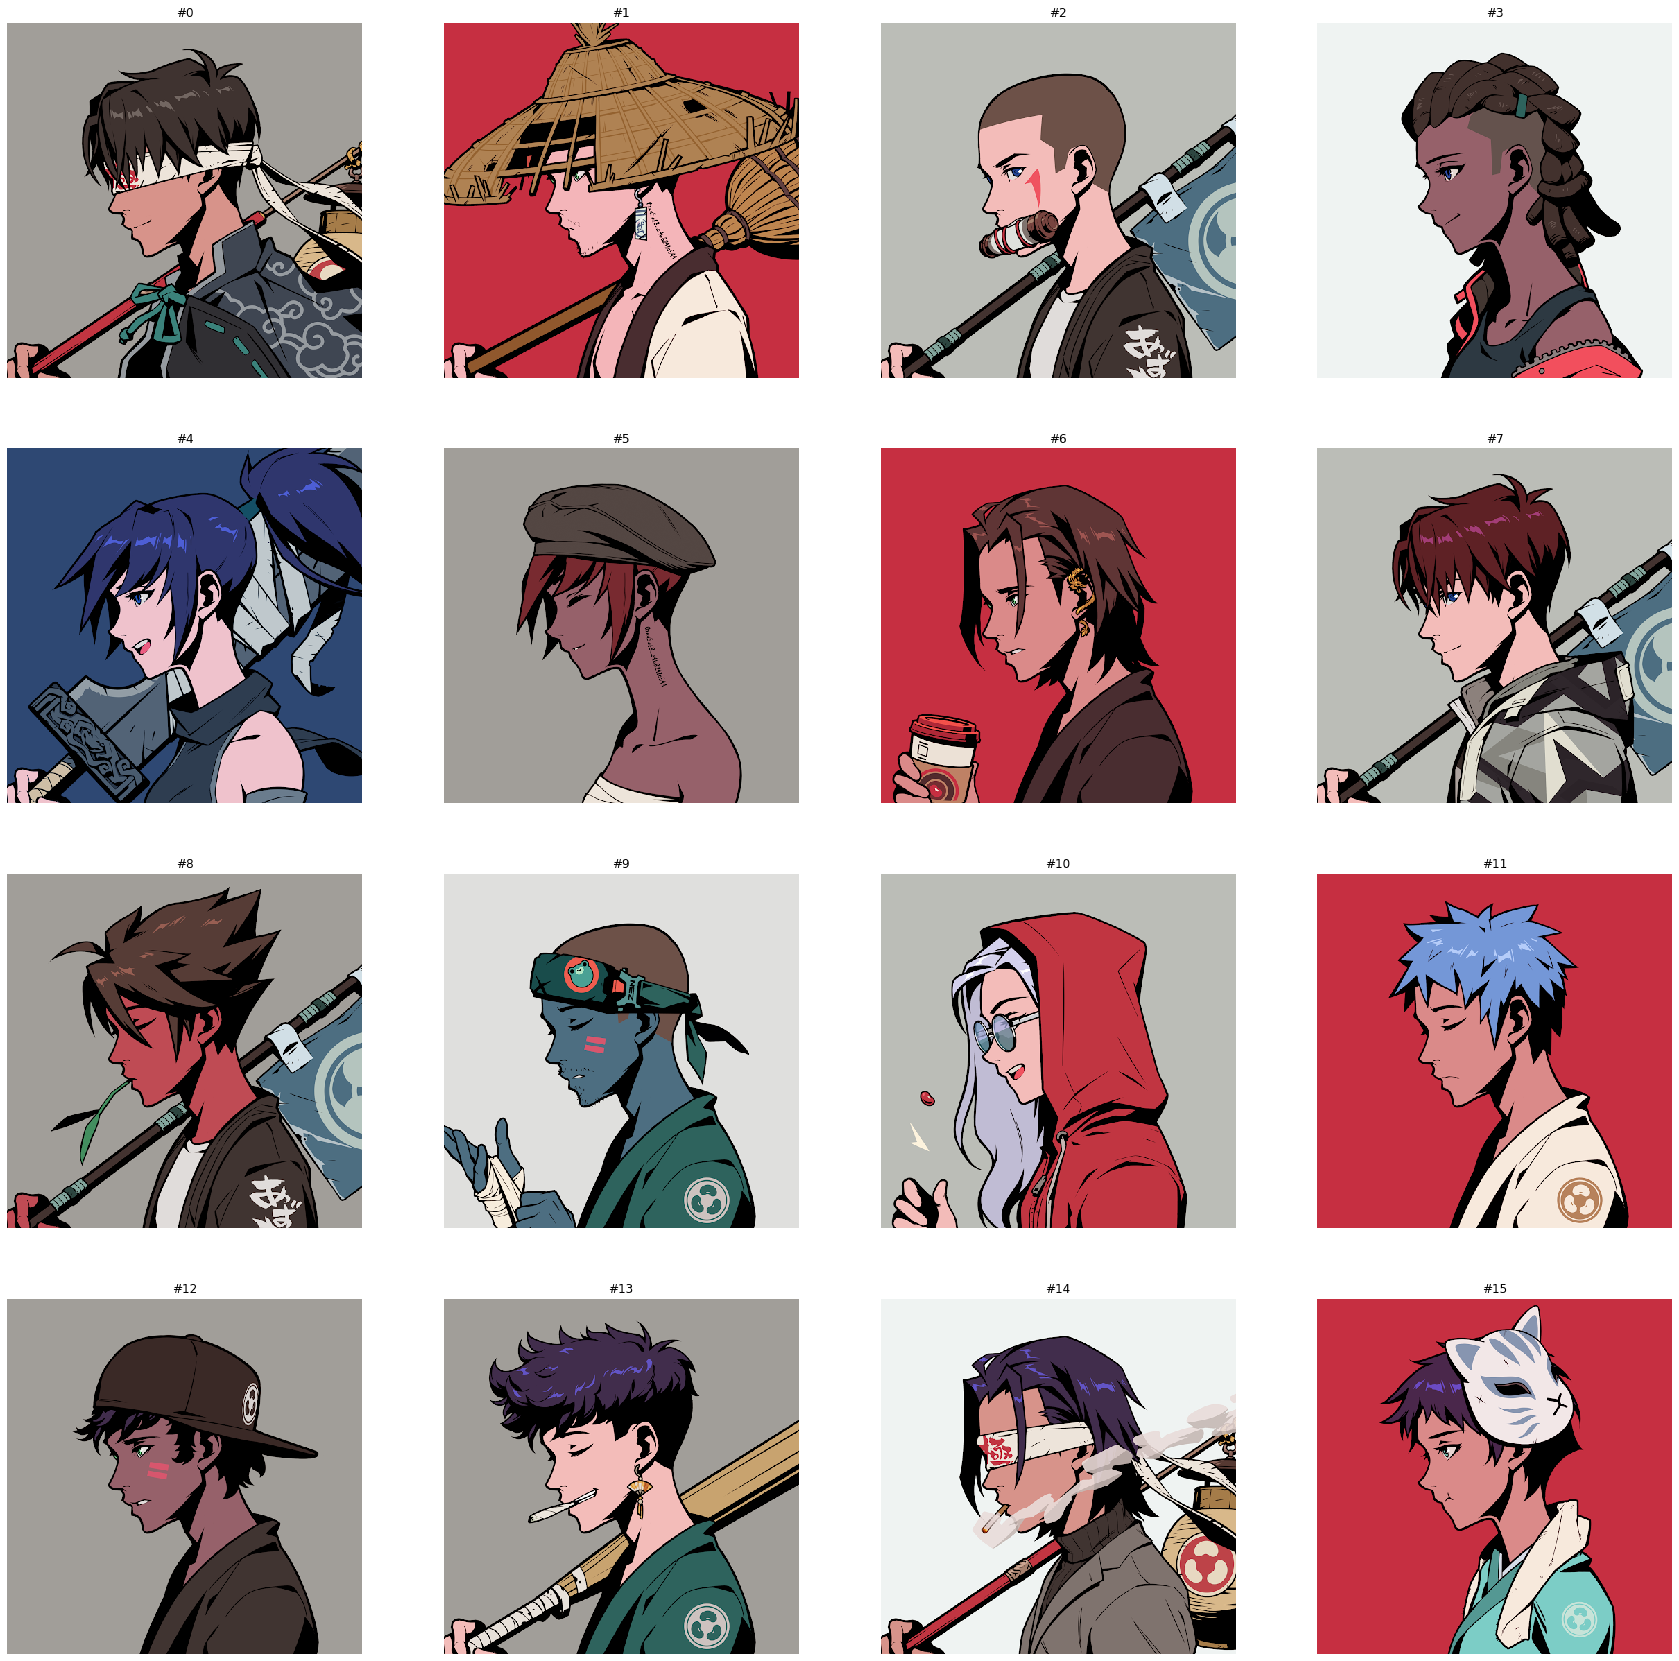

In [6]:
### outputting images of azukis

print("Sample 100 Azukis")
# code for displaying from https://richcorrado.github.io/MNIST_Digits-overview.html
# 4x4 grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30,30))

# counter
i = 0
# axs is a 4x4 array so we flatten it into a vector in order to loop over it
for ax in axs.reshape(-1):
    # title as id
    ax.set_title(f"#{i}")
    ax.imshow(images[i], cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    i += 1
# Tell matplotlib to draw all of the previously generated objects
plt.show()

They look pretty cool, right? Now it's time to train our GAN and make some Red Beans!

### GAN Training

#### Data Loader

To begin with, in thinking about the input to our Deep Convolutional GAN (DCGAN), we implement a DataLoader. A Dataloader is used to parallelize the data loading as this boosts up the speed and saves memory.

In [239]:
def get_dataloader(batch_size, image_size, data_dir, num_workers=3):
    """
    Sets up the dataloader for use.
    Input: batch_size (the size of batches to process), image_size (size of images)
    data_dir (where the images are stored as a path) and number of workers, to dedicate parallelize processing.
    Output: Dataloader object for torch.
    """
    
    # create transformer to transform images
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  #resize
                                    transforms.ToTensor(), #convert to tensor
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize to be between -1 and 1
                                    # https://stackoverflow.com/questions/65467621/what-are-the-numbers-in-torch-transforms-normalize-and-how-to-select-them
    
    # create the dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    # create the dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                              num_workers=num_workers, pin_memory=True)
    
    return data_loader

In [243]:
# test dataloader
batch_size = 128
image_size = 256
image_path = "/content/drive/MyDrive/azuki_images/"
train_loader = get_dataloader(batch_size, image_size, image_path)
# if this runs it works
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/azuki_images/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### Utility Functions

We also need a function to visualise our results as we train the model:

In [244]:
def print_tensor_images(images_tensor):
    """
    Given an RGB tensor, this function outputs an image.
    """
    
    # set up size
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    # number of plots
    no_plots = len(images_tensor)

    # iterate trhough, outputting images
    for i, image in enumerate(npimgs):
        plt.subplot(1, 8, i+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
    
    # show plot
    plt.show()

#helper display function
def tensor_imshow(img, dnorm=True):
    """
    Function to display single tensor image for demo
    """
    img = img.to('cpu') # set to cpu
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    # plt figure
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

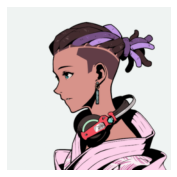

In [245]:
dataiter = iter(train_loader) #dataloader is an iterator

img,_ = next(dataiter)
sample_img = img[-1] # take last img in iter of train_loader

#display tensor image
tensor_imshow(sample_img)

#### Generator & Discriminator

We know a GAN is composed of two adversarial components: the generator and the discriminator. Simply put, the generator tries to make images that look as real as possible. The discriminator then tries to distinguish what is real and what is fake – penalising the generator if it discovers fake data. It is this adversarial relationship that trains the model: the generator progressively gets better at generating images that seem real, and the discriminator gets better at differentiating them.

We set up the generator and discriminator below.

In [246]:
### GENERATOR
# code leveraged from https://medium.com/mlearning-ai/generate-nft-cryptopunks-with-deep-convolutional-generative-adversarial-network-dcgan-db35f0a1adb4

class Generator(nn.Module):

    ## init function
    def __init__(self, noise_dim=100, im_channels=3, hidden_dim=256):
        
        # calls nn __init__ method
        super(Generator, self).__init__()
        self.noise_dim = noise_dim # dimension of noise
        self.im_channels = im_channels # color channels (3)
        self.hidden_dim = hidden_dim # hidden layer dimension
        
        # calls make gen block, setting up sequential nn for generator
        self.generator_cnn = nn.Sequential(self.create_gen_layers(noise_dim, hidden_dim*8, stride=1, padding=0),   
                                           self.create_gen_layers(hidden_dim*8, hidden_dim*4),                           
                                           self.create_gen_layers(hidden_dim*4, hidden_dim*2),                           
                                           self.create_gen_layers(hidden_dim*2, hidden_dim),                             
                                           self.create_gen_layers(hidden_dim, im_channels, final_layer=True))
    

    def create_gen_layers(self, im_channels, output_dim, 
                       kernel_size=4, stride=2, 
                       padding=1, final_layer=False): 
        """
        Main generator construction. We create layers depending on part of nn we are at.
        """
        layers = []
        #de-convolutional layer
        layers.append(nn.ConvTranspose2d(im_channels, output_dim, 
                                         kernel_size, stride, 
                                         padding, bias=False))
        
        # if not final layer, we implement batch norm and leaky relu after 2d conv.
        if not final_layer:
            layers.append(nn.BatchNorm2d(output_dim)) # batched gradient flow
            layers.append(nn.LeakyReLU(0.2)) # activation function 
            # leaky prevents vanishing gradient
            # 0.2 slope leak in all https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
        else:
            layers.append(nn.Tanh()) # we use a tang layer at end
            # scales output between -1 and 1
        
        return nn.Sequential(*layers)

    def forward(self, noise):
        """
        Trains the generator with a forward pass.
        Returns generated images given noise tensor.
        """
        x = noise.view(-1, self.noise_dim, 1, 1)
        return self.generator_cnn(x)

    def get_noise(n_samples, noise_dim, device='cpu'):
        """Generate random noise using the dim and random sampling."""
        return torch.randn(n_samples, noise_dim, device=device)

In [247]:
#test Generator
noise = Generator.get_noise(n_samples=5, noise_dim=100)

g = Generator(noise_dim=100, im_channels=3, hidden_dim=256)
print(f"Printing 0 index noise: \n{noise[0]}")
g

Printing 0 index noise: 
tensor([ 5.7550e-01,  5.7269e-02, -1.4993e+00, -1.0502e+00, -9.9200e-01,
        -1.0955e+00,  1.4590e-01, -1.2897e+00, -1.9658e-01,  4.1713e-01,
         1.9432e-01,  8.6193e-01,  3.3470e-01,  1.4806e-01, -1.4336e+00,
        -2.0002e-01, -4.8339e-01,  3.3631e-01,  2.5995e+00, -1.3506e+00,
         9.7926e-01,  7.5070e-01, -1.8437e+00,  1.1066e+00, -8.3379e-01,
         1.0350e+00, -4.7677e-01, -9.7013e-01,  1.0064e+00,  6.0211e-01,
        -8.6520e-01,  3.1658e-01, -8.8138e-01, -1.3345e+00,  1.0319e+00,
        -5.2807e-02, -3.0918e+00, -2.5284e+00,  1.5123e-01, -5.5967e-01,
        -9.1287e-01, -1.0571e+00, -7.7416e-01,  9.2540e-01,  2.0819e-01,
         9.0114e-01,  7.6523e-02, -6.1377e-01, -1.5042e-01, -2.1985e-03,
         2.7324e-01, -1.6141e+00,  9.9826e-01, -6.0791e-01, -2.8261e-01,
        -1.2913e+00,  1.4950e+00, -1.1614e+00, -9.8856e-01, -1.0037e-01,
        -9.9177e-02, -1.6708e-01, -4.5201e-01, -9.1921e-01, -1.3889e+00,
         5.7961e-02,  4.03

Generator(
  (generator_cnn): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [248]:
### DISCRIMINATOR

class Discriminator(nn.Module):
    # init function
    def __init__(self, im_channels=3, conv_dim=256, image_size=256):
        
        # calls nn init method
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        self.disc_cnn = nn.Sequential(self.create_disc_layers(im_channels, conv_dim, final_layer=False, first_layer=True),
                                      self.create_disc_layers(conv_dim, conv_dim*2),
                                      self.create_disc_layers(conv_dim*2, conv_dim*4),
                                      self.create_disc_layers(conv_dim*4, conv_dim*8),
                                      #no need a sigmoid here since it is included in the loss function
                                      self.create_disc_layers(conv_dim*8, 1, padding=0, final_layer=True, first_layer=False)) 
        
    def create_disc_layers(self, im_channels, output_dim, kernel_size=4,
                           stride=2, padding=1, final_layer=False, first_layer=False):
        """
        Main function for creating discriminator layers for model conditional on final layer.
        """
        layers = []
        layers.append(nn.Conv2d(im_channels, output_dim, kernel_size,
                                stride, padding, bias=False))
        
        if not final_layer and not first_layer:
            layers.append(nn.BatchNorm2d(output_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        elif first_layer and not final_layer:
          layers.append(nn.LeakyReLU(0.2, inplace=True))
          # we dont batch normalise in first layer
          # https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
        
        return nn.Sequential(*layers)
    
    def forward(self, image):
        """
        Forward pass of the discriminator.
        Given an image tensor, returns a 1-dimension tensor representing fake/real.
        """
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0), -1)
        return pred
    
    def _get_final_feature_dimension(self):
        """
        Prints out the shape of the output after the Conv2d layer ran.
        """
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [258]:
#test Discriminator
d = Discriminator(im_channels=3, conv_dim=256, image_size=256)
d

Discriminator(
  (disc_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=

#### Setting up DCGAN

We can now train the model. In order to do so, we need to set up some ways of initialising the model and tracking the performance over time.

- Initialise the weights of the model to a normal distribution (suggested by Goodfellow [here](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf))
- Create a loss function to determine generator and discriminator's loss

In [250]:
def weights_init_normal(m):
    """
    Checks layer in model for conv2d/convtranspose2d or batchnorm2d.
    Initialises weights accordingly for start of training.
    """
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) 
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

For our loss function, we need to calculate real and fake loss. For example, when we feed our discriminator fake images, how many does it classify correctly as fake? Similarly, when we feed it real images, how many does it classify correctly as real?

We use a sigmoid binary-cross entropy function here for classification.

In [259]:
def loss_calc(D_out, device, loss_real):
    """
    Calculate the loss. This is used to evaluate the performance of the discriminator.
    Input the discriminator output. Check if we are calculating real or fake loss (changes labels).
    Output loss.
    """
    
    # combines a sigmoid activation function and binary cross entropy loss in one function.
    criterion = nn.BCEWithLogitsLoss()
    
    # calc batch size
    batch_size = D_out.size(0)
    
    if loss_real == True:
        # labels will be used when calculating the losses
        # real labels = 1 and one-sided label smoothing => 0.9
        labels = torch.ones(batch_size, device=device)*0.9 
    else:
        # if loss is fake, 0s
        labels = torch.zeros(batch_size, device=device) 
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

#### Train DCGAN



We can finally train out model. To keep track of the generators learning properties, we generate a batch of noise drawn from a Gaussian and see how the generator processes it to produce a Red Bean every 10 epochs.

Each epoch, we set up batches from our dataloader and train the model, first generating fake images with the generator, and then classifying the batch with the discriminator. From there, we perform backpropagation to train the generator, using the loss as an indication of success in distinguishing fake (created by generator) from real images.

In [260]:
def train(D, G, n_epochs, dataloader, d_optimizer, g_optimizer, noise_dim, print_every=50, device='cpu'):
    
    # to keep track of the generator’s learning progression, 
    # we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution   
    sample_size = 8
    fixed_z = Generator.get_noise(n_samples=sample_size, noise_dim=noise_dim, device=device)

    # for storing loss
    g_loss_storage = []
    d_loss_storage = []
    
    for epoch in range(1,n_epochs+1):
        # use dataloader to fetch batches
        for batch_i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Part 1: Train the Discriminator ========================================================
            # goal: to maximize the probability of correctly classifying a given input as real or fake
            
            # zero out the gradients before backpropagation
            d_optimizer.zero_grad()
            # classify all-real batch
            d_real_op = D(real_images) # average output (across the batch) of the discriminator
            d_real_loss = loss_calc(d_real_op, device=device, loss_real=True)
            
            # train with all-fake batch
            noise = Generator.get_noise(n_samples=batch_size,
                                        noise_dim=noise_dim,
                                        device=device)
            fake_images = G(noise)
            
            # classify all-fake batch
            d_fake_op = D(fake_images) # average output (across the batch) of the generator
            d_fake_loss = loss_calc(d_fake_op, device=device, loss_real=False)
            
            # total loss
            d_loss = d_real_loss + d_fake_loss
            
            # update gradients
            d_loss.backward()
            # update optimizer
            d_optimizer.step()
            
            # Part 2: Train the Generator ==============================================================
            # zero out the gradients before backpropagation
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        noise_dim=noise_dim,
                                        device=device)
            
            # use discriminator to classify generator's output
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = loss_calc(d_out, device=device, loss_real=True) 
            # update gradients
            g_loss.backward()
            # update optimizer
            g_optimizer.step()
        
        g_loss_storage.append(g_loss.item())
        d_loss_storage.append(d_loss.item())
        print(f"Epoch [{epoch}/{n_epochs}] | d_loss: {np.round(d_loss.item(),2)} | g_loss: {np.round(g_loss.item(),2)}")

        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()
        
    return g_loss_storage, d_loss_storage

In [264]:
# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is", device)

# incorrect hyperparameter settings lead to mode collapse
noise_dim = 100   # noise
beta_1 = 0.5  # these params were specified in https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
beta_2 = 0.999
lr = 0.0002
batch_size = 128
image_size = 64 # im not sure why i can't increase this value

Device is cuda


In [268]:
# initialize generator
generator = Generator(noise_dim, im_channels=3, hidden_dim=64).to(device)

# initialize discriminator
discriminator = Discriminator(im_channels=3, conv_dim=64, image_size=image_size).to(device)

# setup Adam optimizers for generator
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))

# setup Adam optimizers for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

# setup dataloader
dataloader = get_dataloader(batch_size, image_size, "/content/drive/MyDrive/azuki_images/")

Epoch [1/100] | d_loss: 0.58 | g_loss: 2.93
Epoch [2/100] | d_loss: 0.73 | g_loss: 1.5
Epoch [3/100] | d_loss: 0.57 | g_loss: 3.46
Epoch [4/100] | d_loss: 0.61 | g_loss: 2.13
Epoch [5/100] | d_loss: 0.57 | g_loss: 2.46
Epoch [6/100] | d_loss: 0.45 | g_loss: 2.77
Epoch [7/100] | d_loss: 0.68 | g_loss: 2.27
Epoch [8/100] | d_loss: 0.42 | g_loss: 3.43
Epoch [9/100] | d_loss: 0.46 | g_loss: 3.36
Epoch [10/100] | d_loss: 0.38 | g_loss: 5.0


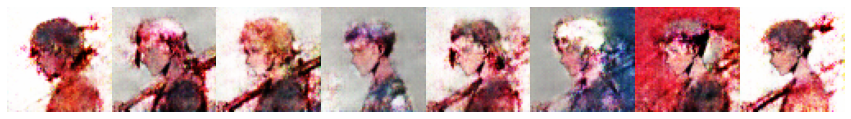

Epoch [11/100] | d_loss: 0.42 | g_loss: 4.06
Epoch [12/100] | d_loss: 0.53 | g_loss: 3.47
Epoch [13/100] | d_loss: 0.48 | g_loss: 1.73
Epoch [14/100] | d_loss: 0.37 | g_loss: 5.38
Epoch [15/100] | d_loss: 0.57 | g_loss: 3.04
Epoch [16/100] | d_loss: 0.51 | g_loss: 2.53
Epoch [17/100] | d_loss: 0.43 | g_loss: 2.82
Epoch [18/100] | d_loss: 0.36 | g_loss: 3.74
Epoch [19/100] | d_loss: 0.36 | g_loss: 4.24
Epoch [20/100] | d_loss: 0.36 | g_loss: 4.32


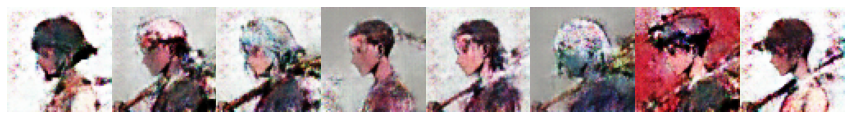

Epoch [21/100] | d_loss: 0.37 | g_loss: 5.3
Epoch [22/100] | d_loss: 0.36 | g_loss: 3.63
Epoch [23/100] | d_loss: 0.4 | g_loss: 3.49
Epoch [24/100] | d_loss: 0.38 | g_loss: 5.29
Epoch [25/100] | d_loss: 0.34 | g_loss: 5.09
Epoch [26/100] | d_loss: 0.37 | g_loss: 4.02
Epoch [27/100] | d_loss: 0.36 | g_loss: 5.18
Epoch [28/100] | d_loss: 0.98 | g_loss: 2.2
Epoch [29/100] | d_loss: 0.36 | g_loss: 4.94
Epoch [30/100] | d_loss: 0.39 | g_loss: 2.71


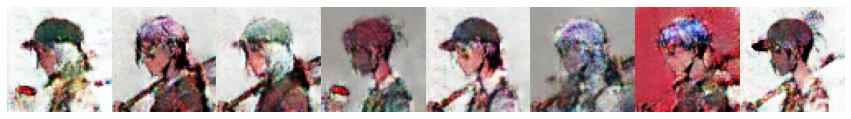

Epoch [31/100] | d_loss: 0.35 | g_loss: 3.87
Epoch [32/100] | d_loss: 0.38 | g_loss: 3.79
Epoch [33/100] | d_loss: 0.39 | g_loss: 6.23
Epoch [34/100] | d_loss: 0.34 | g_loss: 4.95
Epoch [35/100] | d_loss: 0.35 | g_loss: 5.98
Epoch [36/100] | d_loss: 0.37 | g_loss: 4.82
Epoch [37/100] | d_loss: 0.35 | g_loss: 3.4
Epoch [38/100] | d_loss: 0.4 | g_loss: 3.41
Epoch [39/100] | d_loss: 0.35 | g_loss: 6.26
Epoch [40/100] | d_loss: 0.39 | g_loss: 5.53


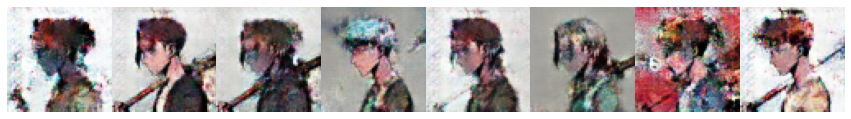

Epoch [41/100] | d_loss: 0.34 | g_loss: 5.71
Epoch [42/100] | d_loss: 0.38 | g_loss: 3.99
Epoch [43/100] | d_loss: 0.35 | g_loss: 4.31
Epoch [44/100] | d_loss: 0.39 | g_loss: 4.59
Epoch [45/100] | d_loss: 0.41 | g_loss: 5.98
Epoch [46/100] | d_loss: 0.53 | g_loss: 2.33
Epoch [47/100] | d_loss: 0.37 | g_loss: 4.88
Epoch [48/100] | d_loss: 0.35 | g_loss: 5.22
Epoch [49/100] | d_loss: 0.37 | g_loss: 3.91
Epoch [50/100] | d_loss: 0.54 | g_loss: 3.9


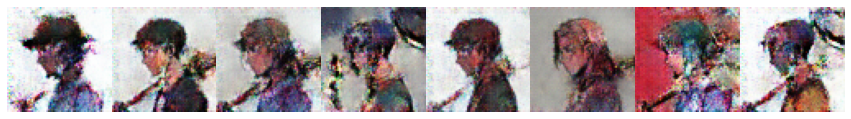

Epoch [51/100] | d_loss: 0.34 | g_loss: 4.67
Epoch [52/100] | d_loss: 0.37 | g_loss: 5.09
Epoch [53/100] | d_loss: 0.36 | g_loss: 4.7
Epoch [54/100] | d_loss: 0.35 | g_loss: 4.37
Epoch [55/100] | d_loss: 0.43 | g_loss: 6.0
Epoch [56/100] | d_loss: 0.36 | g_loss: 5.72
Epoch [57/100] | d_loss: 0.36 | g_loss: 3.51
Epoch [58/100] | d_loss: 0.38 | g_loss: 3.67
Epoch [59/100] | d_loss: 0.4 | g_loss: 5.42
Epoch [60/100] | d_loss: 0.35 | g_loss: 4.97


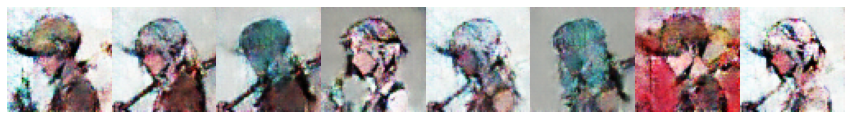

Epoch [61/100] | d_loss: 0.4 | g_loss: 5.34
Epoch [62/100] | d_loss: 0.4 | g_loss: 2.29
Epoch [63/100] | d_loss: 0.35 | g_loss: 6.97
Epoch [64/100] | d_loss: 0.36 | g_loss: 4.33
Epoch [65/100] | d_loss: 0.38 | g_loss: 3.37
Epoch [66/100] | d_loss: 0.61 | g_loss: 1.92
Epoch [67/100] | d_loss: 0.37 | g_loss: 5.59
Epoch [68/100] | d_loss: 0.34 | g_loss: 5.86
Epoch [69/100] | d_loss: 0.4 | g_loss: 4.09
Epoch [70/100] | d_loss: 0.34 | g_loss: 4.87


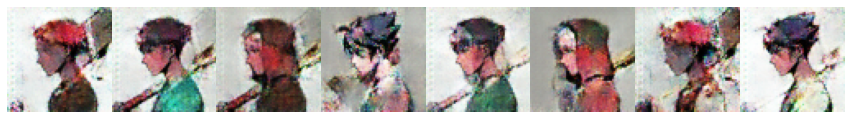

Epoch [71/100] | d_loss: 0.34 | g_loss: 6.72
Epoch [72/100] | d_loss: 0.47 | g_loss: 4.74
Epoch [73/100] | d_loss: 0.54 | g_loss: 1.33
Epoch [74/100] | d_loss: 0.43 | g_loss: 2.75
Epoch [75/100] | d_loss: 0.47 | g_loss: 1.61
Epoch [76/100] | d_loss: 0.42 | g_loss: 1.44
Epoch [77/100] | d_loss: 0.46 | g_loss: 3.07
Epoch [78/100] | d_loss: 0.34 | g_loss: 2.98
Epoch [79/100] | d_loss: 0.36 | g_loss: 5.95
Epoch [80/100] | d_loss: 0.36 | g_loss: 5.6


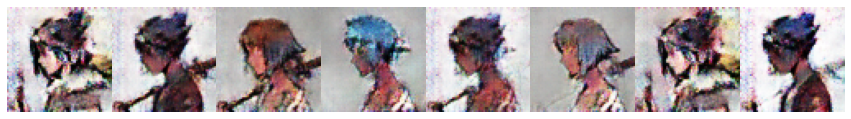

Epoch [81/100] | d_loss: 0.36 | g_loss: 4.3
Epoch [82/100] | d_loss: 0.41 | g_loss: 3.22
Epoch [83/100] | d_loss: 0.37 | g_loss: 4.32
Epoch [84/100] | d_loss: 0.41 | g_loss: 2.9
Epoch [85/100] | d_loss: 0.41 | g_loss: 2.86
Epoch [86/100] | d_loss: 0.45 | g_loss: 2.33
Epoch [87/100] | d_loss: 0.4 | g_loss: 5.33
Epoch [88/100] | d_loss: 0.5 | g_loss: 1.64
Epoch [89/100] | d_loss: 0.35 | g_loss: 3.57
Epoch [90/100] | d_loss: 0.34 | g_loss: 5.93


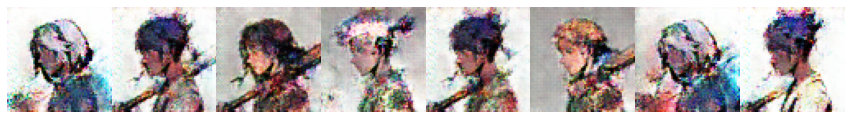

Epoch [91/100] | d_loss: 0.35 | g_loss: 5.58
Epoch [92/100] | d_loss: 0.38 | g_loss: 3.9
Epoch [93/100] | d_loss: 0.35 | g_loss: 7.11
Epoch [94/100] | d_loss: 0.37 | g_loss: 4.61
Epoch [95/100] | d_loss: 0.37 | g_loss: 4.65
Epoch [96/100] | d_loss: 0.35 | g_loss: 4.35
Epoch [97/100] | d_loss: 0.34 | g_loss: 4.76
Epoch [98/100] | d_loss: 0.33 | g_loss: 6.26
Epoch [99/100] | d_loss: 0.62 | g_loss: 3.09
Epoch [100/100] | d_loss: 0.36 | g_loss: 5.55


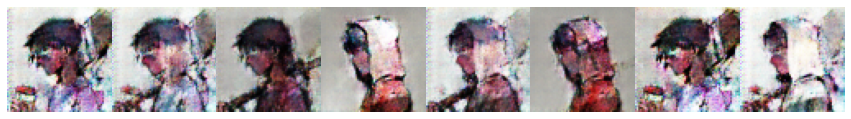

In [269]:
# start training
n_epochs = 100 # 100 epochs seems reasonable for demonstration
g_loss, d_loss = train(discriminator, generator, n_epochs, dataloader, d_optimizer, g_optimizer, noise_dim, print_every=10, device=device)

In [272]:
# save our model if we want to use in future without training.
def save_model(generator,file_name):
    generator = generator.to('cuda')
    torch.save(generator.state_dict(),"azuki_generator1.pth")

save_model(generator,"azuki_gen1")

### Model Evaluation



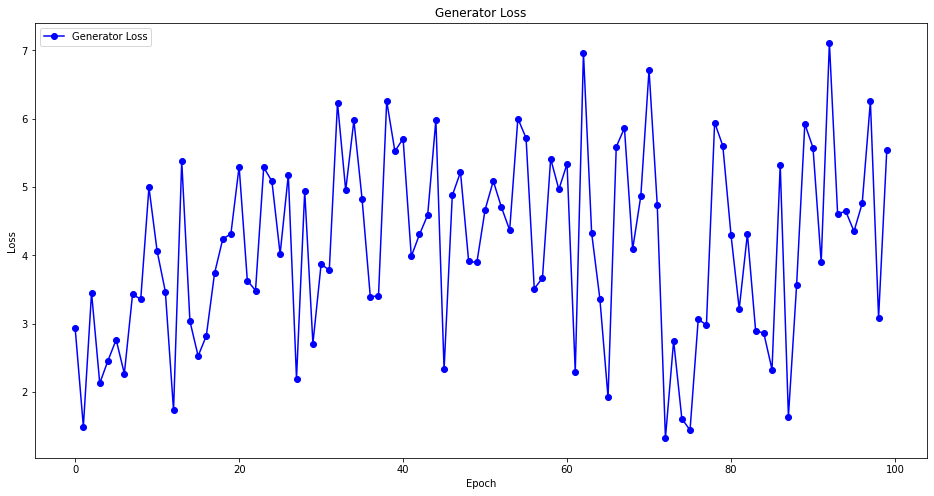

In [291]:
# Plot the learning curve.
plt.figure(figsize=(16,8))
plt.plot(g_loss, 'b-o', label="Generator Loss")


# Label the plot.
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

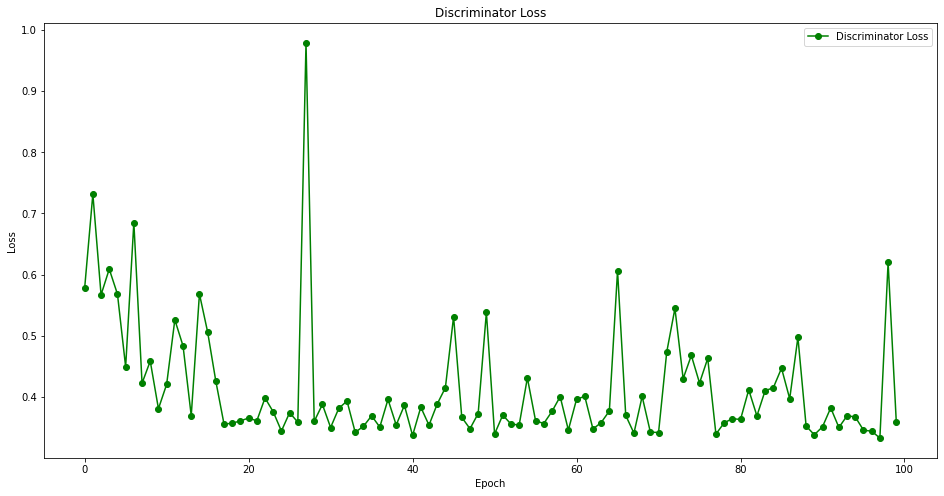

In [290]:
plt.figure(figsize=(16,8))
plt.plot(d_loss, 'g-o', label="Discriminator Loss")
# Label the plot.
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The best way to evaluate our model quantitatively is to analyse the output loss across epochs from our discriminator and generator. 

We can see the generator's loss fluctuates quite a lot between roughly 1.8 and 7.0. The generator loss is then calculated from the classification performance of the discriminator. The generator is rewarded if it fools the discriminator, and gets penalised if it doesn't. This stochastic performance suggests our model is likely not converging. The generator sometimes succeeds and sometimes fails to trick the discriminator. Non-convergence is a fail state of a GAN. While we do not have total non-convergence, there is definitely hyperparameter tuning, more training, and further exploration of the layers in the generator needed to prevent this problem.

The discriminator paints a similar story. As we train our model we want the discriminator's loss to increase. This is because we want the generator to be so good at producing fake images that the discriminator struggles to tell the difference. The ideal loss is this 0.5 (a coin flip). However, we see from our graph that the loss gradually decreases. Our model gets better at telling the difference, and thus the generator is performing relatively poor in comparison to the optimal performance, bar a few epochs when we see the loss increase dramatically.

Fortunately we do not encounter full mode collapse in our model. This occurs when the generator finds a few fake images to generate that can trick the discriminator. The generator then continues to output such images because it gains positive reinforcement, even though these images are not the optimal near-"real" output we desire. As we can see from our output below, there is plenty of variation in the Azukis the model outputs. While some of them do seem to look the same, this is simply natural given the similarity of some Azukis in the collection itself.

### Results

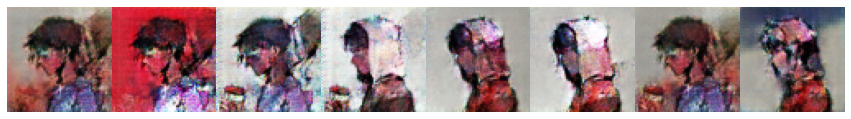

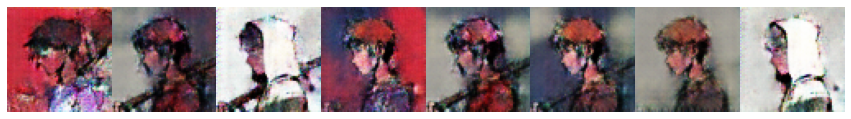

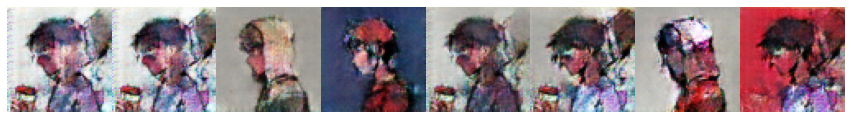

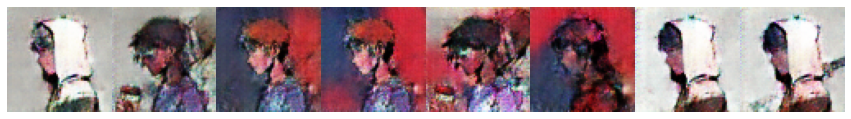

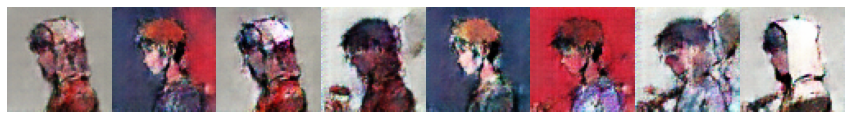

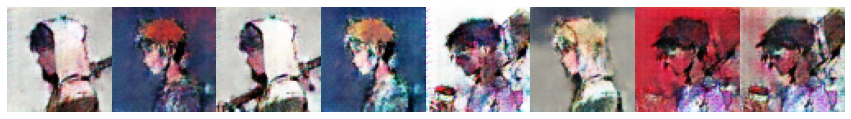

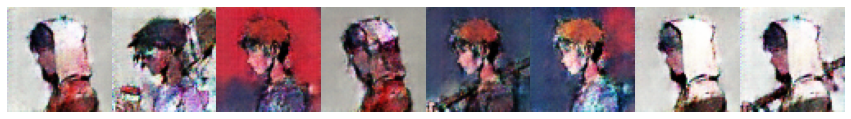

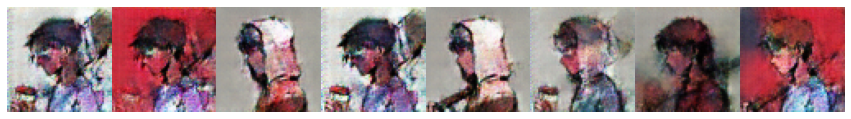

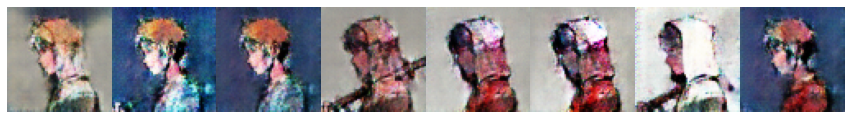

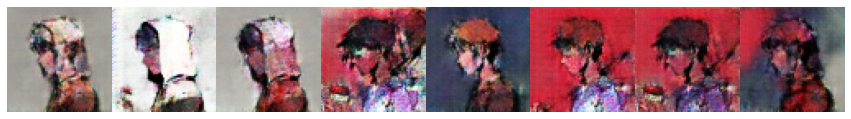

In [274]:
# sample generation
generator.to(device)
generator.eval()
sample_size=8
for i in range(10):
    fixed_z = Generator.get_noise(n_samples=sample_size, noise_dim=noise_dim, device=device)    
    sample_image = generator(fixed_z)
    print_tensor_images(sample_image)

In [285]:
def inspect_redbean(image_tensor):
    """
    Given an RGB tensor, this function outputs an image.
    """
    
    # set up size
    plt.figure(figsize=(5,5))
    
    images_tensor = image_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy().squeeze()
    image = np.transpose(npimgs * 0.5 + 0.5)
    img_rotate = ndimage.rotate(image, 90, reshape=False)
    plt.imshow(img_rotate, origin="bottom")
    
    # show plot
    plt.show()

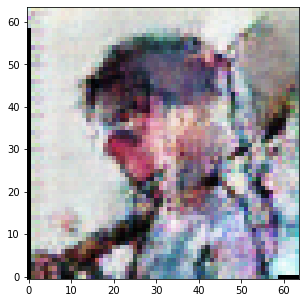

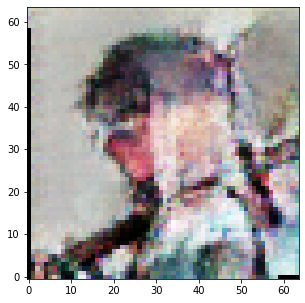

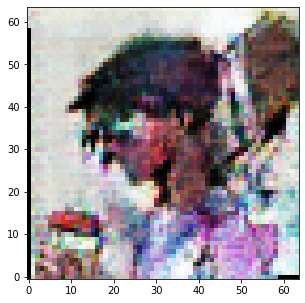

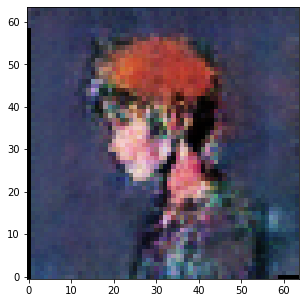

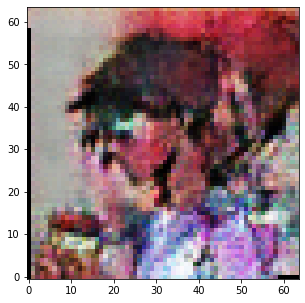

In [289]:
for i in range(0,5):
    fixed_z = Generator.get_noise(n_samples=1, noise_dim=noise_dim, device=device)    
    sample_img = generator(fixed_z)

    #display tensor image
    inspect_redbean(sample_img)

If we look closely, we see that no two Red Beans are exactly the same. We are managing to capture the full shape of the body, weapons, and specific colours, despite the 64x64 pixellation.

The DCGAN has done a relatively good job in producing a unique collection. It is not, however, production ready. If these Red Beans are to be minted, the resolution will need increasing and we will have to refine the model further, as discussed above.

## Interpretation & Future Work

We can see from the results above that there is still work to be done in fine-tuning my model. However, the core infrastructure is there. In order to improve the loss results and the overall look of the Red Beans, we could do the following:

- Increase the resolution.
- Change the loss function.
- Tune the hyperparameters.
- Experiment with different types of random noise.
- Change optimisers.
- Change the initial weight matrix.

A lot of this is experimentation in order to refine the model for this specific task of creating new Azukis.

Regardless, we have taken a good stab at this problem and extensions will likely be made in the final project.

## References

Azuki. (2022). Retrieved from https://www.azuki.com/

Azuki. (2022). Azuki - Collection | OpenSea. Retrieved from https://opensea.io/collection/azuki

BastardGANPunks. (2022). Retrieved from https://bastardganpunks.club/

Bastard GAN Punks. (2022) BASTARD GAN PUNKS - Collection | Opensea. Retrieved from https://opensea.io/collection/bastard-gan-punks

Brownlee, J. (2019). Tips for Training Stable Generative Adversarial Networks. Retrieved from https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

Corrado, R. (2017). MNIST Digit Classification. Retrieved from https://richcorrado.github.io/MNIST_Digits-overview.html

Duong, BT. (2021). Generate NFT CryptoPunks with Deep Convolutional Generative Adversarial Network (DCGAN). Retrieved from https://medium.com/mlearning-ai/generate-nft-cryptopunks-with-deep-convolutional-generative-adversarial-network-dcgan-db35f0a1adb4

GoodFellow, I. (2014). Generative Adversarial Nets. Retrieved from https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf

Gulzar. (2020). What are the numbers in torch.transforms.normalize and how to select them? Retrieved from https://stackoverflow.com/questions/65467621/what-are-the-numbers-in-torch-transforms-normalize-and-how-to-select-them

Thakur, A. (n.d.). How To Use GPU with PyTorch. Retrieved from https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk

Wikipedia. (2022). Red Pill and Blue Pill. Retrieved from https://en.wikipedia.org/wiki/Red_pill_and_blue_pill#:~:text=Neo%20takes%20the%20red%20pill,he%20has%20been%20lying%20unconscious.